### **FeedForward Neural Network (FFNN) - Linear Regression** 

##### Motivation: Include sentiment analysis from the text columns to evaluate if it improves the FFNN model

### *List the imports*

In [2]:
#All the imports
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import multiprocessing
import ssl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to C:\Users\Nabiha
[nltk_data]     Naqvie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Nabiha
[nltk_data]     Naqvie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Nabiha
[nltk_data]     Naqvie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Nabiha
[nltk_data]     Naqvie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### *Selecting Rows & Columns For Analysis*

In [3]:
df_raw = pd.read_csv('games-features.csv')

In [4]:
df_all = df_raw[['QueryName', 'Metacritic',
         #Genre variables
        'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 
         'GenreIsCasual','GenreIsStrategy', 'GenreIsRPG', 'GenreIsSimulation',
       'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'GenreIsSports', 'GenreIsRacing',
         #Category variables
        'CategorySinglePlayer','CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
       'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
       'CategoryIncludeLevelEditor', 'CategoryVRSupport',
         #Platform variables
        'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin',
       'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec',
       'MacReqsHaveMin', 'MacReqsHaveRec',
         #Additional Info
        'RequiredAge', 'DemoCount', 'DeveloperCount', 'DLCCount',
        'MovieCount', 'PackageCount', 'RecommendationCount', 
        'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance','SteamSpyPlayersEstimate', 
         'SteamSpyPlayersVariance','AchievementCount', 'ControllerSupport', 'FreeVerAvail', 
         'PurchaseAvail', 'SubscriptionAvail', 'PriceFinal',
         #Variables that need transformation
         'ReleaseDate', 'SupportedLanguages', 
         #Text variables
         'Reviews','DetailedDescrip','AboutText']]

In [5]:
df = df_all[df_all['Metacritic']>0]

### *Dropping Duplicates*

In [6]:
df = df.drop_duplicates()

In [7]:
df_vc = pd.DataFrame(df['QueryName'].value_counts())
df_vc[df_vc['QueryName']>1]

,QueryName
Sid Meier's Civilization IV: Colonization,2
Monday Night Combat,2
Fallout: New Vegas,2
Darksiders,2
Alpha Protocol,2
Sid Meier's Civilization V,2
Sid Meier's Civilization IV: Beyond the Sword,2
Sid Meier's Civilization IV: Warlords,2
Arma 2,2
Sid Meier's Civilization IV,2


In [8]:
#drop Sid Meier's Civilization IV: Colonization dup 
df=df.drop(965)
#drop Fallout: New Vegas dup
df=df.drop(952)
#drop Sid Meier's Civilization V dup
df=df.drop(1205)
#drop Darksiders dup
df=df.drop(1210)
#drop Sid Meier's Civilization IV dup
df=df.drop(962)
#Drop Monday night combat dup
df=df.drop(1278)
#Drop Sid Meier's Civilization IV: Beyond the Sword dup
df=df.drop(964)
#Drop Sid Meier's Civilization IV: Warlords dup
df=df.drop(963)
#Drop Arma 2 dup
df=df.drop(782)
#Drop Alpha Protocol dup
df=df.drop(961)

### *Cleaning Languages*

In [9]:
import re
pd.set_option('display.max_rows', None)
languages = df['SupportedLanguages'].tolist()

#Split to check all languages
split_lst = []
for language in languages:
    split_lang = re.split('\* |\*|\s|\*\*', language)
    for lang in split_lang:
        split_lst.append(lang)

split_series = pd.Series(split_lst)
split_df = pd.DataFrame(split_series.value_counts())

In [10]:
#Create list of all possible languages
language_list=['English', 'German', 'French', 'Spanish',  'Italian', 'Russian', 'Polish', 
               'Japanese', 'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 
               'Dutch', 'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish', 
               'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai', 'Greek', 
               'Bulgarian', 'Arabic',  'Slovakian']

In [11]:
#Create boolean columns for each language
for language in language_list:
    df[language]=df['SupportedLanguages'].str.contains(language)

In [12]:
#create boolean column for audio support (will delete later, using this as reference to check regex)
df.loc[df['SupportedLanguages'].str.contains("languages with full audio support")==True, 'audio_support?'] = 1
df.loc[df['SupportedLanguages'].str.contains("languages with full audio support")==False, 'audio_support?'] = 0

In [13]:
#Create transformed language columns without "languages with full audio support" statement
df['transformed']= df['SupportedLanguages'].str.extract("(.+?)\*languages with full audio support")

In [14]:
#Count * in transformed column to count number of languages with audio support
df['num_lang_audio_support']=df['transformed'].str.count('\*')
df['num_lang_audio_support'] = df['num_lang_audio_support'].fillna(0)

In [15]:
pd.set_option('display.max_columns', None)
df.head(5)

,QueryName,Metacritic,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,CategorySinglePlayer,CategoryMultiplayer,CategoryCoop,CategoryMMO,CategoryInAppPurchase,CategoryIncludeSrcSDK,CategoryIncludeLevelEditor,CategoryVRSupport,PlatformWindows,PlatformLinux,PlatformMac,PCReqsHaveMin,PCReqsHaveRec,LinuxReqsHaveMin,LinuxReqsHaveRec,MacReqsHaveMin,MacReqsHaveRec,RequiredAge,DemoCount,DeveloperCount,DLCCount,MovieCount,PackageCount,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,AchievementCount,ControllerSupport,FreeVerAvail,PurchaseAvail,SubscriptionAvail,PriceFinal,ReleaseDate,SupportedLanguages,Reviews,DetailedDescrip,AboutText,English,German,French,Spanish,Italian,Russian,Polish,Japanese,Portuguese-Brazil,Czech,Korean,Simplified Chinese,Dutch,Traditional Chinese,Portuguese,Hungarian,Turkish,Swedish,Danish,Norwegian,Finnish,Ukrainian,Romanian,Thai,Greek,Bulgarian,Arabic,Slovakian,audio_support?,transformed,num_lang_audio_support
0,Counter-Strike,88,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,0,0,1,68991,13,13033334,92789,9140731,78136,0,False,False,True,False,9.99,Nov 1 2000,English French German Italian Spanish Simplifi...,,Play the worlds number 1 online action game. E...,Play the worlds number 1 online action game. E...,True,True,True,True,True,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,NaN,0.0
2,Day of Defeat,79,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,0,0,1,2319,5,7621102,71499,1709740,34145,0,False,False,True,False,4.99,May 1 2003,English French German Italian Spanish,,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,NaN,0.0
6,Half-Life,96,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,1,0,1,12486,11,5927504,63206,2268772,39303,0,False,False,True,False,9.99,Nov 8 1998,English French German Italian Spanish Simplifi...,,Named Game of the Year by over 50 publications...,Named Game of the Year by over 50 publications...,True,True,True,True,True,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,NaN,0.0
7,Counter-Strike: Condition Zero,65,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,0,0,1,0,0,1,7067,8,10489261,83543,4127910,52878,0,False,False,True,False,9.99,Mar 1 2004,English French German Italian Spanish Simplifi...,,With its extensive Tour of Duty campaign a nea...,With its extensive Tour of Duty campaign a nea...,True,True,True,True,True,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,NaN,0.0
9,Half-Life: Blue Shift,71,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,0,0,1,2219,5,5368650,60199,662517,21286,0,False,False,True,False,4.99,Jun 1 2001,English French German,,Made by Gearbox Software and originally releas...,Made by Gearbox Software and originally releas...,True,True,True,False,False,False,False,False,False,Fa

In [16]:
#Convert bool to numeric and sum
df[['English', 'German', 'French', 'Spanish',  'Italian', 'Russian', 'Polish', 
               'Japanese', 'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 
               'Dutch', 'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish', 
               'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai', 'Greek', 
               'Bulgarian', 'Arabic',  'Slovakian']] = df[['English', 'German', 'French', 'Spanish',  'Italian', 'Russian', 'Polish', 
               'Japanese', 'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 
               'Dutch', 'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish', 
               'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai', 'Greek', 
               'Bulgarian', 'Arabic',  'Slovakian']].replace({True: 1, False: 0})

df['num_languages']=df[['English', 'German', 'French', 'Spanish',  'Italian', 'Russian', 'Polish', 
               'Japanese', 'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 
               'Dutch', 'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish', 
               'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai', 'Greek', 
               'Bulgarian', 'Arabic',  'Slovakian']].sum(axis=1)

In [17]:
#Drop columns used in transformations
df=df.drop("transformed", axis=1)
df=df.drop("audio_support?", axis=1)

In [18]:
pd.set_option('display.max_columns', None)
df.head(5)

,QueryName,Metacritic,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,CategorySinglePlayer,CategoryMultiplayer,CategoryCoop,CategoryMMO,CategoryInAppPurchase,CategoryIncludeSrcSDK,CategoryIncludeLevelEditor,CategoryVRSupport,PlatformWindows,PlatformLinux,PlatformMac,PCReqsHaveMin,PCReqsHaveRec,LinuxReqsHaveMin,LinuxReqsHaveRec,MacReqsHaveMin,MacReqsHaveRec,RequiredAge,DemoCount,DeveloperCount,DLCCount,MovieCount,PackageCount,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,AchievementCount,ControllerSupport,FreeVerAvail,PurchaseAvail,SubscriptionAvail,PriceFinal,ReleaseDate,SupportedLanguages,Reviews,DetailedDescrip,AboutText,English,German,French,Spanish,Italian,Russian,Polish,Japanese,Portuguese-Brazil,Czech,Korean,Simplified Chinese,Dutch,Traditional Chinese,Portuguese,Hungarian,Turkish,Swedish,Danish,Norwegian,Finnish,Ukrainian,Romanian,Thai,Greek,Bulgarian,Arabic,Slovakian,num_lang_audio_support,num_languages
0,Counter-Strike,88,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,0,0,1,68991,13,13033334,92789,9140731,78136,0,False,False,True,False,9.99,Nov 1 2000,English French German Italian Spanish Simplifi...,,Play the worlds number 1 online action game. E...,Play the worlds number 1 online action game. E...,1,1,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8
2,Day of Defeat,79,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,0,0,1,2319,5,7621102,71499,1709740,34145,0,False,False,True,False,4.99,May 1 2003,English French German Italian Spanish,,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,5
6,Half-Life,96,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,1,0,1,12486,11,5927504,63206,2268772,39303,0,False,False,True,False,9.99,Nov 8 1998,English French German Italian Spanish Simplifi...,,Named Game of the Year by over 50 publications...,Named Game of the Year by over 50 publications...,1,1,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8
7,Counter-Strike: Condition Zero,65,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,0,0,1,0,0,1,7067,8,10489261,83543,4127910,52878,0,False,False,True,False,9.99,Mar 1 2004,English French German Italian Spanish Simplifi...,,With its extensive Tour of Duty campaign a nea...,With its extensive Tour of Duty campaign a nea...,1,1,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8
9,Half-Life: Blue Shift,71,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,True,False,True,False,True,False,0,0,1,0,0,1,2219,5,5368650,60199,662517,21286,0,False,False,True,False,4.99,Jun 1 2001,English French German,,Made by Gearbox Software and originally releas...,Made by Gearbox Software and originally releas...,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3


### *Cleaning Dates*

In [19]:
#Check for dates with inaccurate format
df['ReleaseDate'][df['ReleaseDate'].str.fullmatch('[a-zA-Z]{3}\s\d*?\s\d{4}')==False]

305                Feb 2011
529                        
572                        
668                Jun 2009
687                Jul 2010
904                Sep 2009
1008                       
1180               Mar 2010
1199                       
1228               Apr 2010
1253               Jul 2010
1268               Oct 2010
1269               Oct 2010
1578                       
1856                       
1922                       
1993                       
2171                       
2183                       
2201                       
2214                       
2317               Aug 2013
3805               Nov 2014
4103               May 2015
4943               Jun 2015
12068    December 20th 2016
Name: ReleaseDate, dtype: object

In [20]:
#Convert these dates to accurate format, replace blanks with NAs
df['ReleaseDate']= df['ReleaseDate'].replace({'Oct 2010': 'Oct 1 2010', 'Jul 2010':'Jul 1 2010', 'Aug 2013': 'Aug 2013',
                          'Jun 2015': 'Jun 1 2015', 'December 20th 2016': 'Dec 20 2016',
                          'May 2015': 'May 1 2015', 'Nov 2014': 'Nov 1 2014', 'Sep 2009':'Sep 1 2009',
                          'Jun 2009': 'Jun 1 2009', 'Feb 2011':'Feb 1 2011', 'Mar 2010':'Mar 1 2010',
                          'Apr 2010': 'Apr 1 2010', 'Aug 2013': 'Aug 1 2013'})
df['ReleaseDate'] = df['ReleaseDate'].replace(r'^\s*$', np.nan, regex=True)

In [21]:
#Convert to datetime
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

In [22]:
#check data type
df['ReleaseDate'].dtype

dtype('<M8[ns]')

In [23]:
df.describe()

,Metacritic,RequiredAge,DemoCount,DeveloperCount,DLCCount,MovieCount,PackageCount,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,AchievementCount,PriceFinal,English,German,French,Spanish,Italian,Russian,Polish,Japanese,Portuguese-Brazil,Czech,Korean,Simplified Chinese,Dutch,Traditional Chinese,Portuguese,Hungarian,Turkish,Swedish,Danish,Norwegian,Finnish,Ukrainian,Romanian,Thai,Greek,Bulgarian,Arabic,Slovakian,num_lang_audio_support,num_languages
count,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2.235000e+03,2235.000000,2.235000e+03,2235.000000,2.235000e+03,2235.000000,2235.000000,2235.000000,2235.0,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.00000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000
mean,72.008501,2.508277,0.186577,1.087696,1.502013,1.798210,1.680984,4.552546e+03,11.968680,5.867512e+05,13742.305145,4.127886e+05,10733.005369,26.519911,14.024385,1.0,0.607159,0.587472,0.532886,0.474273,0.351678,0.234004,0.161074,0.153020,0.085906,0.078747,0.076510,0.069799,0.05906,0.187919,0.051007,0.044743,0.036242,0.032215,0.029083,0.027740,0.015660,0.013870,0.008949,0.008949,0.008949,0.008501,0.000447,1.216555,4.945861
std,11.152135,5.984335,0.391950,0.362037,5.995998,1.829089,1.023349,3.541729e+04,7.336697,2.455699e+06,14185.781091,2.313979e+06,12541.438116,53.770134,10.488378,0.0,0.488491,0.492399,0.499029,0.499449,0.477601,0.423470,0.367681,0.360087,0.280288,0.269404,0.265872,0.254864,0.23579,0.390735,0.220061,0.206785,0.186933,0.176610,0.168076,0.164265,0.124184,0.116979,0.094194,0.094194,0.094194,0.091829,0.021152,2.172011,4.165792
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,66.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.370000e+02,8.000000,3.560100e+04,4938.000000,1.721800e+04,3434.000000,0.000000,8.365000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,73.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,5.180000e+02,10.000000,1.303870e+05,9449.000000,6.725600e+04,6787.000000,15.000000,9.990000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,80.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.118500e+03,14.000000,4.602110e+05,17745.000000,2.679480e+05,13543.500000,39.000000,19.990000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000
max,96.000000,18.000000,2.000000,5.000000,169.000000,20.000000,11.000000,1.427633e+06,114.000000,9.068758e+07,215972.000000,9.068758e+07,215972.000000,1448.000000,99.990000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [24]:
#Create game_age variable
now = pd.to_datetime('now')
df['Game_Age']=(now - df['ReleaseDate']).dt.total_seconds() / (60*60*24*365.25)

#make columns for month, drop date column
#df_lr['Year'] = df_lr['ReleaseDate'].dt.year 
df['Month'] = df['ReleaseDate'].dt.month_name()
df=df.drop('ReleaseDate', axis=1)

#Make dummy variables for months
df = pd.concat([df, pd.get_dummies(df['Month'])], axis=1)
df = df.drop('Month', axis=1)

#Make booleans numeric
df=df.replace({True: 1, False: 0})

#shuffle rows
df_shuffled= df.sample(frac=1, random_state=1).reset_index()
df_shuffled.shape

(2235, 97)

### *Preprocessing the Text Column*

In [25]:
#Create column of review text with all lowercase, no punctuation, and no stopwords
nan_value = float("NaN") #Create na variable for blanks
df_shuffled["AboutText"].replace("", nan_value, inplace=True) #Replace blanks with na variable
df_shuffled.dropna(subset = ["AboutText"], inplace=True) #Drop all rows with na review text
df_shuffled["abouttext"] = df_shuffled["AboutText"].str.replace('[^\w\s]','',regex=True) #Create column with review text with no punctuation
df_shuffled["abouttext"] = df_shuffled["abouttext"].str.lower() #Make all words lowercase
stopwords = nltk.corpus.stopwords.words('english') #Create stopwords variable
df_shuffled["abouttext"] = df_shuffled["abouttext"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #Remove stop words
df_shuffled["abouttext"].replace("abouttext", nan_value, inplace=True,regex=True) #Replace blanks with na
df_shuffled.dropna(subset = ["abouttext"], inplace=True) #Drop all rows with na review text, reset indices
df_shuffled = df_shuffled.sample(frac = 1).reset_index() #Randomize resulting dataframe and reset indices

In [26]:
df_shuffled["texttoken"] = df_shuffled.apply(lambda row: word_tokenize(row["abouttext"]), axis=1)

In [27]:
www = WordNetLemmatizer()
def lemmatize_text(text):
    return [www.lemmatize(w) for w in text]
df_shuffled['texttoken'] = df_shuffled.texttoken.apply(lemmatize_text)
df_shuffled['textLemma'] = df_shuffled['texttoken'].apply(' '.join)

### Include the Sentiment Analyzer: VADER

In [28]:
#Insert column with VADER sentiment analysis compound score of full review text, scale numbers from 1 to 5
vader = SentimentIntensityAnalyzer()
df_shuffled["vadercompound"] = [vader.polarity_scores(x)['compound'] for x in df_shuffled['AboutText']]
scaler = MinMaxScaler(feature_range=(1,5))
df_shuffled["vadercompound"] = scaler.fit_transform(df_shuffled["vadercompound"].values.reshape(-1,1))

In [29]:
df_shuffled["wordCount"] = df_shuffled["texttoken"].apply(len)

count    2235.000000
mean      153.106935
std        86.370378
min         0.000000
25%        96.000000
50%       135.000000
75%       191.000000
max       830.000000
Name: wordCount, dtype: float64


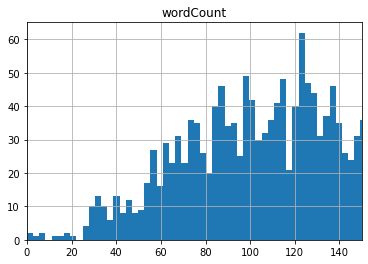

In [30]:
wordhist = df_shuffled.hist(column = 'wordCount', bins=300)
plt.xlim([0,150])
print(df_shuffled["wordCount"].describe())

In [31]:
list(df_shuffled)

['level_0',
 'index',
 'QueryName',
 'Metacritic',
 'GenreIsNonGame',
 'GenreIsIndie',
 'GenreIsAction',
 'GenreIsAdventure',
 'GenreIsCasual',
 'GenreIsStrategy',
 'GenreIsRPG',
 'GenreIsSimulation',
 'GenreIsEarlyAccess',
 'GenreIsFreeToPlay',
 'GenreIsSports',
 'GenreIsRacing',
 'CategorySinglePlayer',
 'CategoryMultiplayer',
 'CategoryCoop',
 'CategoryMMO',
 'CategoryInAppPurchase',
 'CategoryIncludeSrcSDK',
 'CategoryIncludeLevelEditor',
 'CategoryVRSupport',
 'PlatformWindows',
 'PlatformLinux',
 'PlatformMac',
 'PCReqsHaveMin',
 'PCReqsHaveRec',
 'LinuxReqsHaveMin',
 'LinuxReqsHaveRec',
 'MacReqsHaveMin',
 'MacReqsHaveRec',
 'RequiredAge',
 'DemoCount',
 'DeveloperCount',
 'DLCCount',
 'MovieCount',
 'PackageCount',
 'RecommendationCount',
 'ScreenshotCount',
 'SteamSpyOwners',
 'SteamSpyOwnersVariance',
 'SteamSpyPlayersEstimate',
 'SteamSpyPlayersVariance',
 'AchievementCount',
 'ControllerSupport',
 'FreeVerAvail',
 'PurchaseAvail',
 'SubscriptionAvail',
 'PriceFinal',
 'Supp

### *Include Warriner Analyzer*

In [32]:
#get the words for each emotion
WarrinerWords = pd.read_csv("https://raw.githubusercontent.com/JULIELab/EmoMap/master/coling18/main/lexicon_creation/lexicons/Warriner_BE.tsv", sep='\t')
JoyDict = dict(zip(WarrinerWords.Word, WarrinerWords.Joy))
AngerDict = dict(zip(WarrinerWords.Word, WarrinerWords.Anger))
SadnessDict = dict(zip(WarrinerWords.Word, WarrinerWords.Sadness))
FearDict = dict(zip(WarrinerWords.Word, WarrinerWords.Fear))
DisgustDict = dict(zip(WarrinerWords.Word, WarrinerWords.Disgust))

In [33]:
#initalize the columns to 0
df_shuffled['Joy'] = 0.0
df_shuffled['Anger'] = 0.0
df_shuffled['Sadness'] = 0.0
df_shuffled['Fear'] = 0.0
df_shuffled['Disgust'] = 0.0

In [34]:
#append each word/token with the emotion score
for index, row in df_shuffled.iterrows():
    for word in row['texttoken']:
        df_shuffled.at[index,'Joy'] += JoyDict.get(word,0)
        df_shuffled.at[index,'Anger'] += AngerDict.get(word,0)
        df_shuffled.at[index,'Sadness'] += SadnessDict.get(word,0)
        df_shuffled.at[index,'Fear'] += FearDict.get(word,0)
        df_shuffled.at[index,'Disgust'] += DisgustDict.get(word,0)

In [35]:
#Take into account the word count
df_shuffled['Joy'] = df_shuffled['Joy'] / df_shuffled['wordCount']
df_shuffled['Anger'] = df_shuffled['Anger'] / df_shuffled['wordCount']
df_shuffled['Sadness'] = df_shuffled['Sadness'] / df_shuffled['wordCount']
df_shuffled['Fear'] = df_shuffled['Fear'] / df_shuffled['wordCount']
df_shuffled['Disgust'] = df_shuffled['Disgust'] / df_shuffled['wordCount']

# *Feed Forward Neural Network*

In [36]:
# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
sns.set(style="darkgrid")  # default style
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras import metrics
tf.get_logger().setLevel('INFO')

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

In [37]:
#include only the Warriner Emotion scores here
dffinal = df_shuffled[['Metacritic','GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
        'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
        'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
        'GenreIsSports', 'GenreIsRacing', 'CategorySinglePlayer',
        'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
        'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
        'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'PlatformWindows',
        'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
        'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
        'MacReqsHaveRec', 'RequiredAge', 'DemoCount', 'DeveloperCount',
        'DLCCount', 'MovieCount', 'PackageCount', 'RecommendationCount',
        'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
        'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
        'AchievementCount', 'ControllerSupport', 'FreeVerAvail',
        'PurchaseAvail', 'SubscriptionAvail', 'PriceFinal', 'English', 'German',
        'French', 'Spanish', 'Italian', 'Russian', 'Polish', 'Japanese',
        'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 'Dutch',
        'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish',
        'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai',
        'Greek', 'Bulgarian', 'Arabic', 'Slovakian', 'num_lang_audio_support',
        'April', 'August', 'December', 'February', 'January', 'July',
        'June', 'March', 'May', 'November', 'October', 'September', 'Joy','Anger','Sadness','Fear','Disgust']]

In [38]:
df_lr = dffinal.dropna()
df_lr = df_lr[df_lr['Metacritic'] != 0]
df_lr.head()

,Metacritic,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,CategorySinglePlayer,CategoryMultiplayer,CategoryCoop,CategoryMMO,CategoryInAppPurchase,CategoryIncludeSrcSDK,CategoryIncludeLevelEditor,CategoryVRSupport,PlatformWindows,PlatformLinux,PlatformMac,PCReqsHaveMin,PCReqsHaveRec,LinuxReqsHaveMin,LinuxReqsHaveRec,MacReqsHaveMin,MacReqsHaveRec,RequiredAge,DemoCount,DeveloperCount,DLCCount,MovieCount,PackageCount,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,AchievementCount,ControllerSupport,FreeVerAvail,PurchaseAvail,SubscriptionAvail,PriceFinal,English,German,French,Spanish,Italian,Russian,Polish,Japanese,Portuguese-Brazil,Czech,Korean,Simplified Chinese,Dutch,Traditional Chinese,Portuguese,Hungarian,Turkish,Swedish,Danish,Norwegian,Finnish,Ukrainian,Romanian,Thai,Greek,Bulgarian,Arabic,Slovakian,num_lang_audio_support,April,August,December,February,January,July,June,March,May,November,October,September,Joy,Anger,Sadness,Fear,Disgust
0,69,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,2,321,5,89854,7845,41788,5350,0,0,0,1,0,4.99,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1.824023,0.916167,0.894589,0.947798,0.883554
1,69,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,3,2,3,2682,13,1229262,28972,614990,20509,49,0,0,1,0,9.99,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,1.645798,0.962943,0.953267,1.004688,0.935394
2,85,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,17,0,1,1,2,2,30833,7,2037232,37255,1764262,34683,35,0,0,1,0,9.99,1,1,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1.453226,1.239680,1.195254,1.301084,1.197920
3,57,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,10,66180,6733,13631,3055,6,0,0,1,0,14.99,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,1.935435,1.000197,0.979614,1.031503,0.970875
4,58,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,3,1,1346,31,169306,10767,124827,9246,12,1,0,1,0,6.99,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,1.671287,1.023859,1.013396,1.113615,0.964125


In [42]:
features = ['GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
        'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
        'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
        'GenreIsSports', 'GenreIsRacing', 'CategorySinglePlayer',
        'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
        'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
        'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'PlatformWindows',
        'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
        'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
        'MacReqsHaveRec', 'RequiredAge', 'DemoCount', 'DeveloperCount',
        'DLCCount', 'MovieCount', 'PackageCount', 'RecommendationCount',
        'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
        'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
        'AchievementCount', 'ControllerSupport', 'FreeVerAvail',
        'PurchaseAvail', 'SubscriptionAvail', 'PriceFinal', 'English', 'German',
        'French', 'Spanish', 'Italian', 'Russian', 'Polish', 'Japanese',
        'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 'Dutch',
        'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish',
        'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai',
        'Greek', 'Bulgarian', 'Arabic', 'Slovakian', 'num_lang_audio_support',
        'RequiredAge', 'April', 'August', 'December', 'February', 'January', 'July',
        'June', 'March', 'May', 'November', 'October', 'September', 'Joy','Anger','Sadness','Fear','Disgust']

In [43]:
# Use a ~80/20 train/test split.
lr_train = df_lr[:1835]
lr_test = df_lr[1835:]

# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
X_train = lr_train[features].values
X_test = lr_test[features].values
y_train = lr_train['Metacritic'].values
y_test = lr_test['Metacritic'].values

# Confirm the data shapes are as expected.
print('train data shape:', X_train.shape)
print('train labels shape:', y_train.shape)
print('test data shape:', X_test.shape)
print('test labels shape:', y_test.shape)

train data shape: (1835, 94)
train labels shape: (1835,)
test data shape: (398, 94)
test labels shape: (398,)


In [44]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [45]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1835, 94)
(398, 94)


In [80]:
import tensorflow as tf
def build_model(num_features, hidden_layer_sizes=[]):
    """Return a simple linear regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

  # Use Keras Sequential API to build a linear regression model.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    # Add hidden layers with activation and dropout regularization.
    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense(units=hidden_layer_size, activation='relu'))

    model.add(tf.keras.layers.Dropout(rate=0.1))
    
    # create output layer
    model.add(tf.keras.layers.Dense(
      activation = None,          # linear activation is used
      units=1,                    # there is a single output
      use_bias=True               # include a learned bias parameter
      ))
  
    initial_learning_rate = 0.1 
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000, #orginally 100000
    decay_rate=0.1, #originally 0.96
    staircase=True)
  # Use mean squared error as our loss and the Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Build a model
model = build_model(num_features=X_train_scaled.shape[1], hidden_layer_sizes=[128, 256])

Epoch 1/10
37/37 [==============================] - 1s 5ms/step - loss: 828.8735 - val_loss: 212.1846
Epoch 2/10
37/37 [==============================] - 0s 2ms/step - loss: 142.9109 - val_loss: 151.8746
Epoch 3/10
37/37 [==============================] - 0s 2ms/step - loss: 103.6663 - val_loss: 155.7323
Epoch 4/10
37/37 [==============================] - 0s 2ms/step - loss: 88.0841 - val_loss: 141.4449
Epoch 5/10
37/37 [==============================] - 0s 2ms/step - loss: 81.7153 - val_loss: 134.7161
Epoch 6/10
37/37 [==============================] - 0s 2ms/step - loss: 76.8821 - val_loss: 185.2506
Epoch 7/10
37/37 [==============================] - 0s 2ms/step - loss: 76.6736 - val_loss: 173.1541
Epoch 8/10
37/37 [==============================] - 0s 2ms/step - loss: 68.2623 - val_loss: 155.7331
Epoch 9/10
37/37 [==============================] - 0s 2ms/step - loss: 66.4548 - val_loss: 191.8131
Epoch 10/10
37/37 [==============================] - 0s 2ms/step - loss: 61.9355 - val_l

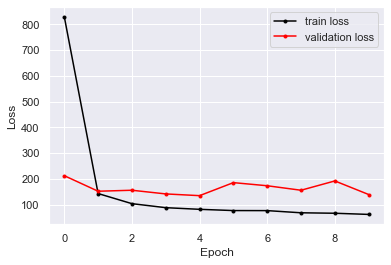

Final train loss: 61.93550109863281
Final test loss: 139.15084838867188


,loss,val_loss
0,828.873474,212.184616
1,142.910858,151.874573
2,103.666328,155.732269
3,88.084129,141.444901
4,81.715271,134.716064
5,76.882126,185.250626
6,76.673576,173.154144
7,68.262299,155.733139
8,66.454849,191.813141
9,61.935501,139.150848


In [81]:
def plot_loss(model, history):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame.
    history = pd.DataFrame(history.history)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

  # Show the final train loss value and the learned model weights.
    print('Final train loss:', list(history['loss'])[-1])
    print('Final test loss:', list(history['val_loss'])[-1])
    #print('Final weights:', model.layers[0].get_weights())
    
history = model.fit(
  x = X_train_scaled,
  y = y_train,
  epochs=10,
  batch_size=50,
  validation_split=0.01,
  verbose=1
)

plot_loss(model, history)

history = pd.DataFrame(history.history)
display(history)

In [82]:
test_results = model.evaluate(
    X_test_scaled,
    y_test, verbose=0)

print("MSE for test data:")
print(test_results)

MSE for test data:
136.75636291503906


#### Experimentation
HIDDEN SIZES | EPOCH | TrainLoss | ValidationLoss| Learning Rate | Test MSE 
-|-|-|-|-|-
[64]|10|68.9394|162.0588|0.01|127.86640167236328
[64]|10|105.3637|182.9796|0.1|142.2216339111328
[128]|10|67.8005|143.8344|0.01|123.98251342773438
[128]|10| 85.4023|168.5928|0.1|124.5726318359375
[256]|10|60.8766|118.0033|0.01|124.66766357421875
[256]|10|69.1529 |121.5698|0.1|126.32862854003906
[64, 128]|10|64.9474|112.5100|0.01|137.71348571777344
[64, 128]|10|72.7990|101.5648|0.1|130.9615020751953
[64, 256]|10|67.5578 |150.7316|0.01|136.4916229248047
[64, 256]|10|69.9479|101.9551|0.1|135.7540283203125
[128, 256]|10|59.6008|171.9728|0.01|119.98973846435547
[128, 256]|10|61.9355|139.1508|0.1|136.75636291503906


### *CODE WITH VADER SENTIMENT ANALYSIS*

In [83]:
dffinal = df_shuffled[['Metacritic','GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
        'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
        'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
        'GenreIsSports', 'GenreIsRacing', 'CategorySinglePlayer',
        'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
        'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
        'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'PlatformWindows',
        'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
        'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
        'MacReqsHaveRec', 'RequiredAge', 'DemoCount', 'DeveloperCount',
        'DLCCount', 'MovieCount', 'PackageCount', 'RecommendationCount',
        'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
        'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
        'AchievementCount', 'ControllerSupport', 'FreeVerAvail',
        'PurchaseAvail', 'SubscriptionAvail', 'PriceFinal', 'English', 'German',
        'French', 'Spanish', 'Italian', 'Russian', 'Polish', 'Japanese',
        'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 'Dutch',
        'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish',
        'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai',
        'Greek', 'Bulgarian', 'Arabic', 'Slovakian', 'num_lang_audio_support',
        'April', 'August', 'December', 'February', 'January', 'July',
        'June', 'March', 'May', 'November', 'October', 'September', 'vadercompound']]

In [84]:
df_lr = dffinal.dropna()
df_lr = df_lr[df_lr['Metacritic'] != 0]
df_lr.head()

,Metacritic,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,CategorySinglePlayer,CategoryMultiplayer,CategoryCoop,CategoryMMO,CategoryInAppPurchase,CategoryIncludeSrcSDK,CategoryIncludeLevelEditor,CategoryVRSupport,PlatformWindows,PlatformLinux,PlatformMac,PCReqsHaveMin,PCReqsHaveRec,LinuxReqsHaveMin,LinuxReqsHaveRec,MacReqsHaveMin,MacReqsHaveRec,RequiredAge,DemoCount,DeveloperCount,DLCCount,MovieCount,PackageCount,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,AchievementCount,ControllerSupport,FreeVerAvail,PurchaseAvail,SubscriptionAvail,PriceFinal,English,German,French,Spanish,Italian,Russian,Polish,Japanese,Portuguese-Brazil,Czech,Korean,Simplified Chinese,Dutch,Traditional Chinese,Portuguese,Hungarian,Turkish,Swedish,Danish,Norwegian,Finnish,Ukrainian,Romanian,Thai,Greek,Bulgarian,Arabic,Slovakian,num_lang_audio_support,April,August,December,February,January,July,June,March,May,November,October,September,vadercompound
0,69,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,2,321,5,89854,7845,41788,5350,0,0,0,1,0,4.99,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,4.962768
1,69,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,3,2,3,2682,13,1229262,28972,614990,20509,49,0,0,1,0,9.99,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,2.449432
2,85,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,17,0,1,1,2,2,30833,7,2037232,37255,1764262,34683,35,0,0,1,0,9.99,1,1,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1.045639
3,57,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,10,66180,6733,13631,3055,6,0,0,1,0,14.99,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,4.980583
4,58,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,3,1,1346,31,169306,10767,124827,9246,12,1,0,1,0,6.99,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,4.527999


In [85]:
features = ['GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
        'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
        'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
        'GenreIsSports', 'GenreIsRacing', 'CategorySinglePlayer',
        'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
        'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
        'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'PlatformWindows',
        'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
        'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
        'MacReqsHaveRec', 'RequiredAge', 'DemoCount', 'DeveloperCount',
        'DLCCount', 'MovieCount', 'PackageCount', 'RecommendationCount',
        'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
        'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
        'AchievementCount', 'ControllerSupport', 'FreeVerAvail',
        'PurchaseAvail', 'SubscriptionAvail', 'PriceFinal', 'English', 'German',
        'French', 'Spanish', 'Italian', 'Russian', 'Polish', 'Japanese',
        'Portuguese-Brazil', 'Czech', 'Korean', 'Simplified Chinese', 'Dutch',
        'Traditional Chinese', 'Portuguese', 'Hungarian', 'Turkish', 'Swedish',
        'Danish', 'Norwegian', 'Finnish', 'Ukrainian', 'Romanian', 'Thai',
        'Greek', 'Bulgarian', 'Arabic', 'Slovakian', 'num_lang_audio_support',
        'RequiredAge', 'April', 'August', 'December', 'February', 'January', 'July',
        'June', 'March', 'May', 'November', 'October', 'September', 'vadercompound']

In [86]:
# Use a ~80/20 train/test split.
lr_train = df_lr[:1835]
lr_test = df_lr[1835:]

# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
X_train = lr_train[features].values
X_test = lr_test[features].values
y_train = lr_train['Metacritic'].values
y_test = lr_test['Metacritic'].values

# Confirm the data shapes are as expected.
print('train data shape:', X_train.shape)
print('train labels shape:', y_train.shape)
print('test data shape:', X_test.shape)
print('test labels shape:', y_test.shape)

train data shape: (1835, 90)
train labels shape: (1835,)
test data shape: (400, 90)
test labels shape: (400,)


In [87]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [122]:
import tensorflow as tf
def build_model(num_features, hidden_layer_sizes=[]):
    """Return a simple linear regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

  # Use Keras Sequential API to build a linear regression model.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    # Add hidden layers with activation and dropout regularization.
    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense(units=hidden_layer_size, activation='relu'))

    model.add(tf.keras.layers.Dropout(rate=0.1))
    
    # create output layer
    model.add(tf.keras.layers.Dense(
      activation = None,          # linear activation is used
      units=1,                    # there is a single output
      use_bias=True               # include a learned bias parameter
      ))
  
    initial_learning_rate = 0.1 
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000, #orginally 100000
    decay_rate=0.1, #originally 0.96
    staircase=True)
  # Use mean squared error as our loss and the Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Build a model
model = build_model(num_features=X_train_scaled.shape[1], hidden_layer_sizes=[128, 256])

Epoch 1/10
34/34 [==============================] - 1s 7ms/step - loss: 1063.5815 - val_loss: 210.5829
Epoch 2/10
34/34 [==============================] - 0s 2ms/step - loss: 228.4773 - val_loss: 189.7921
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 124.5561 - val_loss: 175.7491
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 92.9796 - val_loss: 170.5709
Epoch 5/10
34/34 [==============================] - 0s 2ms/step - loss: 80.8634 - val_loss: 158.3157
Epoch 6/10
34/34 [==============================] - 0s 2ms/step - loss: 76.1251 - val_loss: 175.8790
Epoch 7/10
34/34 [==============================] - 0s 2ms/step - loss: 141.4933 - val_loss: 176.9692
Epoch 8/10
34/34 [==============================] - 0s 2ms/step - loss: 92.5804 - val_loss: 187.7506
Epoch 9/10
34/34 [==============================] - 0s 3ms/step - loss: 80.1814 - val_loss: 185.1295
Epoch 10/10
34/34 [==============================] - 0s 2ms/step - loss: 70.9257 - val

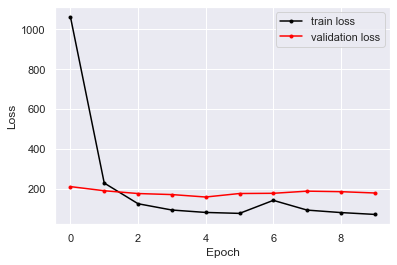

Final train loss: 70.9256591796875
Final test loss: 178.53451538085938


,loss,val_loss
0,1063.581543,210.582886
1,228.477325,189.792114
2,124.556122,175.749146
3,92.979645,170.570877
4,80.863426,158.315704
5,76.125114,175.878983
6,141.493271,176.969193
7,92.580421,187.750580
8,80.181396,185.129517
9,70.925659,178.534515


In [123]:
def plot_loss(model, history):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame.
    history = pd.DataFrame(history.history)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

  # Show the final train loss value and the learned model weights.
    print('Final train loss:', list(history['loss'])[-1])
    print('Final test loss:', list(history['val_loss'])[-1])
    #print('Final weights:', model.layers[0].get_weights())
    
history = model.fit(
  x = X_train_scaled,
  y = y_train,
  epochs=10,
  batch_size=50,
  validation_split=0.1,
  verbose=1
)

plot_loss(model, history)

history = pd.DataFrame(history.history)
display(history)

In [124]:
test_results = model.evaluate(
    X_test_scaled,
    y_test, verbose=0)

print("MSE for test data:")
print(test_results)

MSE for test data:
127.37602233886719


#### Experimentation
HIDDEN SIZES | EPOCH | TrainLoss | ValidationLoss| Learning Rate | Test MSE 
-|-|-|-|-|-
[64]|10|89.6840|157.0943|0.01|138.1769561767578
[64]|10|111.9208|149.0811|0.1|134.697265625
[128]|10|74.1688|141.7700|0.01|126.79356384277344
[128]|10| 90.5699|150.4034|0.1|134.2897186279297
[256]|10|69.1854|133.6904|0.01|131.18826293945312
[256]|10|79.4581 | 143.6367|0.1|130.27919006347656
[64, 128]|10|59.0674 |170.9922|0.01|127.1166763305664
[64, 128]|10|75.8167|169.7577|0.1|130.13412475585938
[64, 256]|10|62.6159 |155.1595|0.01|141.21051025390625
[64, 256]|10|67.1275|166.3678|0.1|137.80259704589844
[128, 256]|10|68.4696 |143.3365|0.01|122.13026428222656
[128, 256]|10|70.9257|178.5345|0.1|127.37602233886719
